In [1]:
#https://github.com/vinayprabhu/sub-sequence-search
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from scipy.spatial import distance
from scipy.stats import zscore

#https://github.com/yosuah/vgg_deconv_vis/blob/master/Visualise%20convolution%20kernels.ipynb
import tensorflow as tf
from tensorflow.python.ops import gen_nn_ops

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def fastfindNNPre(x, m):
    n = len(x)  # m = len(y)  

    # matlab : x(n+1:2*n) = 0; => n+1 ~ 2n 길이의 0행렬을 x에 더함
    x = np.concatenate((x, np.zeros((2*n - n))))
    
    X = np.fft.fft(x)
    cum_sumx=np.cumsum(x)
    cum_sumx2=np.cumsum(x ** 2)
    sumx2=cum_sumx2[m:n] - cum_sumx2[0:n-m]
    sumx=cum_sumx[m:n] - cum_sumx[0:n-m]
    meanx=sumx / m
    sigmax2=(sumx2 / m) - (meanx ** 2)
    sigmax=np.sqrt(sigmax2) 
    
    return X, n, sumx2, sumx, meanx, sigmax2, sigmax

def fastfindNN(X, y, n, m, sumx2, sumx, meanx, sigmax2, sigmax):
    dropval = y[0]
    y = y[::-1];#Reverse the query
    
    # matlab : y(m+1:2*n) = 0; => m+1 ~ 2n 길이의 0행렬을 y에 더함, x의 길이와 같아짐 
    y = np.concatenate((y, np.zeros((2*n - m))))

    #The main trick of getting dot products in O(n log n) time
    Y = np.fft.fft(y)
    Z = X*Y
    z = np.fft.ifft(Z)
    
    #compute y stats -- O(n)
    sumy = sum(y)
    sumy2 = sum(y ** 2)
    meany=sumy/m
    sigmay2 = (sumy2/m)-(meany **2)
    sigmay = np.sqrt(sigmay2)                          

    dist = 2*(m-(z[m:n]-m*meanx*meany)/(sigmax*sigmay))
    dist = np.sqrt(dist)
    lastz = np.real(z[m:n])
    
    return dist, lastz, dropval, sumy, sumy2

In [3]:
def TSC1_chainlength(A, SubsequenceLength):
    #set trivial match exclusion zone
    exclusionZone = round(SubsequenceLength/4);
    
    #check input
    if SubsequenceLength > len(A)/2:
        error('Error: Time series is too short relative to desired subsequence length')
    elif SubsequenceLength < 4 :
        error('Error: Subsequence length must be at least 4');
    
    #initialization
    MatrixProfileLength = len(A) - SubsequenceLength
    MPLeft=np.tile(np.inf,(MatrixProfileLength,1)) #numpy tile : repeat matrix
    MPindexLeft=np.zeros((MatrixProfileLength,1))
    MPRight=np.tile(np.inf,(MatrixProfileLength,1))
    MPindexRight=np.zeros((MatrixProfileLength, 1))
    X,n,sumx2,sumx,meanx,sigmax2,sigmax=fastfindNNPre(A,SubsequenceLength)

    #compute the matrix profile
    pickedIdx = np.arange(MatrixProfileLength)
    dropval=0
    distanceProfile=np.zeros((MatrixProfileLength,1))
    lastz=np.zeros((MatrixProfileLength,1))
    updatePosLeft=np.full((MatrixProfileLength,1),False)
    updatePosRight=np.full((MatrixProfileLength,1),False)

    for i in range(MatrixProfileLength):
        idx=pickedIdx[i]
        subsequence=A[idx:idx + SubsequenceLength]
        distanceProfile[:,0],lastz,dropval,lastsumy,lastsumy2=fastfindNN(X,subsequence,n,SubsequenceLength,sumx2,sumx,meanx,sigmax2,sigmax)

        if i == 0:
            distanceProfile[:,0]=abs(distanceProfile[:,0])
            firstz=lastz

        else:
            lastsumy=lastsumy - dropval + subsequence[-1]
            lastsumy2=lastsumy2 - dropval ** 2 + subsequence[-1] ** 2

            meany=lastsumy / SubsequenceLength
            sigmay2=lastsumy2 / SubsequenceLength - meany ** 2
            sigmay=np.sqrt(sigmay2)
            lastz[1:n - SubsequenceLength+2]=lastz[0:n - SubsequenceLength-1]- (A[0:n - SubsequenceLength-1] * dropval)\
                    + A[SubsequenceLength:n-1]* subsequence[-1]
            lastz[0]=firstz[i]
            distanceProfile[:,0]=np.sqrt(2*(SubsequenceLength - (lastz - (SubsequenceLength*meanx*meany)) / (sigmax*sigmay)))
            dropval=subsequence[1]

        exclusionZoneStart = max(1, idx-exclusionZone)
        exclusionZoneEnd = min(MatrixProfileLength, idx+exclusionZone)
        distanceProfile[exclusionZoneStart:exclusionZoneEnd] = np.inf

        # figure out and store the neareest neighbor
        updatePosLeft[1:(idx-1)] = False
        updatePosLeft[idx:MatrixProfileLength] = distanceProfile[idx:MatrixProfileLength] < MPLeft[idx:MatrixProfileLength]
        MPLeft[updatePosLeft] = distanceProfile[updatePosLeft]
        MPindexLeft[updatePosLeft] = idx

        updatePosRight[(idx+1):MatrixProfileLength] = False
        updatePosRight[1:idx] = distanceProfile[1:idx] < MPRight[1:idx]
        MPRight[updatePosRight] = distanceProfile[updatePosRight]
        MPindexRight[updatePosRight]= idx
        
    ChainPos = np.full((MatrixProfileLength,1),False)
    ChainLength = np.zeros((MatrixProfileLength,1))

    for i in range(MatrixProfileLength):
        if (~ChainPos[i]):
            cur=i
            count=1
            #while int(MPindexRight[cur])>0 and int(MPindexLeft[int(MPindexRight[cur])])==cur:
            while MPindexRight[int(cur)]>0 and MPindexLeft[int(MPindexRight[int(cur)])]==cur:
                ChainPos[int(cur)]=True
                cur=MPindexRight[int(cur)]
                count=count+1
            ChainLength[i]=count
    
    #Note that ChainLength and ChainPos show all possible chains within the time series. 
    #The following code only outputs the longest chain possible, 
    #but actually with these two vectors, we can show any chain within the time series. 
    
    #anchor가 없는 경우만으로 단순화
    ChainStart = np.argmax(ChainLength)
    count=int(ChainLength[ChainStart])
    
    curmax=0
    curmin=0
    curmaxdiff=0
    curmindiff=0

    cur=ChainStart
    next_num=ChainStart
    lastpattern=[]

    for i in range(count):
        next_num=MPindexRight[int(cur)]
        curpattern=zscore(A[int(cur):int(cur+SubsequenceLength)])
        if max(curpattern)>curmax :
            curmax=max(curpattern)
        if min(curpattern)<curmin :
            curmin=min(curpattern) 
        if i>=2 :
            diff=curpattern-lastpattern
            val1=max(diff)
            val2=min(diff)
            if val1>curmaxdiff :
                curmaxdiff=val1
            if val2<curmindiff :
                curmindiff=val2
        lastpattern=curpattern
        cur=next_num
    
    #one showing the chain within the time series
    i =1
    cur=int(ChainStart)
    lastpattern=[]
    
    plt.figure()
    plt.plot(A)
    while i<=count:  
        plt.plot(np.arange(int(cur),int(cur+SubsequenceLength)),A[int(cur):int(cur+SubsequenceLength)],'r')
        cur=MPindexRight[int(cur)]
        i=i+1
    plt.title("the chain within the time series")
    
    # the other enumerating all the subsequence in the chain, 
    # and at the same time showing the difference between every two subsequences in the chain.
    plt.figure()
    i=1
    cur=int(ChainStart)
    lastpattern=[]

    while i<=count:
        plt.subplot(np.ceil(count/count),count,i)
        curpattern=zscore(A[int(cur):int(cur+SubsequenceLength)])
        plt.plot(np.arange(int(cur),int(cur+SubsequenceLength)),curpattern)
        plt.xlim([cur,cur+SubsequenceLength])
        plt.ylim([curmin,curmax])
        if i>1 :
            plt.hold(True)
            plt.plot(np.arange(int(cur),int(cur+SubsequenceLength)),-lastpattern+curpattern,'r')
        cur=MPindexRight[int(cur)]
        lastpattern=curpattern
        i=i+1
        
    plt.show()
    
    ########## fro evalutate robust
    MaxChainLength=np.max(ChainLength)
    ChainStart = np.argmax(ChainLength)

    cur=ChainStart
    i=1
    count=MaxChainLength

    Ldiscovered=np.zeros((1, len(A)))

    while i<=count:
        Ldiscovered[0, cur:(cur+SubsequenceLength)]=1
        cur=int(MPindexRight[cur])
        i=i+1

    return MaxChainLength, Ldiscovered, cur

In [4]:
database_path = '../Data/'
dirname = 'OSULeaf'

train_path = database_path + dirname + '/' + dirname + '_TRAIN'
test_path  = database_path + dirname + '/' + dirname + '_TEST'

train_file = np.loadtxt(train_path, delimiter=',')
test_file = np.loadtxt(test_path, delimiter=',')

#rawdata = np.concatenate((train_file, test_file))
data_train = train_file[:,1:]
labels_train = train_file[:,0].astype(int) - 1 #label starts from 0

data_test = test_file[:,1:]
labels_test = test_file[:,0].astype(int) - 1 #label starts from 0

for i in range(len(labels_train)):
    if labels_train[i] == -2 :
        labels_train[i] = 1

class_list, each_class_num = np.unique(labels_train, return_counts=True)
n_class = len(class_list)
x_dim = data_train.shape[1]
labels_train = np.eye(n_class)[labels_train.astype(np.int32)]

for i in range(len(labels_test)):
    if labels_test[i] == -2 :
        labels_test[i] = 1
        
labels_test = np.eye(n_class)[labels_test.astype(np.int32)]

In [5]:
def deepnn(x):
    with tf.name_scope('reshape'):
        x_image = tf.reshape(x, [-1, 1, x_dim, 1])

    with tf.name_scope('conv1'):
        W_conv1 = weight_variable([1, 5, 1, 16])
        b_conv1 = bias_variable([16])
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        
    with tf.name_scope('pool1'):
        h_pool1 = max_pool_2x2(h_conv1)

    with tf.name_scope('conv2'):
        W_conv2 = weight_variable([1, 5, 16, 32])
        b_conv2 = bias_variable([32])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    with tf.name_scope('pool2'):
        h_pool2 = max_pool_2x2(h_conv2)

    with tf.name_scope('conv3'):
        W_conv3 = weight_variable([1, 5, 32, 64])
        b_conv3 = bias_variable([64])
        h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)

    with tf.name_scope('pool3'):
        h_pool3 = max_pool_2x2(h_conv3)     
       
    with tf.name_scope('fc1'):
        n_out = int(h_pool3.shape[2]*h_pool3.shape[3])
        W_fc1 = weight_variable([n_out, 512])
        b_fc1 = bias_variable([512])

        h_pool3_flat = tf.reshape(h_pool3, [-1, n_out])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)
    
    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    with tf.name_scope('fc2'):
        W_fc2 = weight_variable([512, n_class])
        b_fc2 = bias_variable([n_class])
 
        y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2    
    return y_conv, keep_prob

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 1, 2, 1], strides=[1, 1, 2, 1], padding='SAME')

def weight_variable(shape):
    initial = tf.random_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [6]:
# Create the model
x = tf.placeholder(tf.float32, [None, x_dim])

# Define loss and optimizer
y_ = tf.placeholder(tf.int32, [None, n_class])
#y_onehot = tf.one_hot(y_, n_class)

# Build the graph for the deep net
y_conv, keep_prob = deepnn(x)

with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_,logits=y_conv)
    cross_entropy = tf.reduce_mean(cross_entropy)

with tf.name_scope('adam_optimizer'):
    train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

#graph_location = tempfile.mkdtemp()

graph_location = 'Deconv_Timeseries/tf_log'
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph())
batch_size = 100

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(300):
    
        train_step.run(feed_dict={x: data_train, y_: labels_train, keep_prob: 0.8})
            
        if epoch % 50 == 0:
            train_accuracy = accuracy.eval(feed_dict={x: data_train, y_: labels_train, keep_prob: 1.0})
            print('epoch %d, training accuracy %g' % (epoch, train_accuracy))

    print('test accuracy %g' % accuracy.eval(feed_dict={x: data_test, y_: labels_test, keep_prob: 1.0}))

Saving graph to: Deconv_Timeseries/tf_log
epoch 0, training accuracy 0.265
epoch 50, training accuracy 0.6
epoch 100, training accuracy 1
epoch 150, training accuracy 1
epoch 200, training accuracy 1
epoch 250, training accuracy 1
test accuracy 0.561983


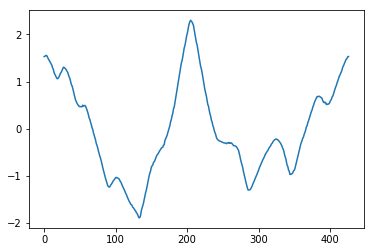

In [7]:
sequence = np.expand_dims(data_test[25],0)
plt.plot(sequence.squeeze())

In [8]:
for op in tf.get_default_graph().get_operations():
    print(str(op.name))

Placeholder
Placeholder_1
reshape/Reshape/shape
reshape/Reshape
conv1/random_normal/shape
conv1/random_normal/mean
conv1/random_normal/stddev
conv1/random_normal/RandomStandardNormal
conv1/random_normal/mul
conv1/random_normal
conv1/Variable
conv1/Variable/Assign
conv1/Variable/read
conv1/Const
conv1/Variable_1
conv1/Variable_1/Assign
conv1/Variable_1/read
conv1/Conv2D
conv1/add
conv1/Relu
pool1/MaxPool
conv2/random_normal/shape
conv2/random_normal/mean
conv2/random_normal/stddev
conv2/random_normal/RandomStandardNormal
conv2/random_normal/mul
conv2/random_normal
conv2/Variable
conv2/Variable/Assign
conv2/Variable/read
conv2/Const
conv2/Variable_1
conv2/Variable_1/Assign
conv2/Variable_1/read
conv2/Conv2D
conv2/add
conv2/Relu
pool2/MaxPool
conv3/random_normal/shape
conv3/random_normal/mean
conv3/random_normal/stddev
conv3/random_normal/RandomStandardNormal
conv3/random_normal/mul
conv3/random_normal
conv3/Variable
conv3/Variable/Assign
conv3/Variable/read
conv3/Const
conv3/Variable_1
c

In [9]:
def plotAllActivations(layer, sequence):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        g = tf.get_default_graph()
        output_tensor = g.get_operation_by_name(layer).outputs[0]
        input_tensor = g.get_operation_by_name('Placeholder').outputs[0]
        units = sess.run(output_tensor, feed_dict={input_tensor: sequence, keep_prob:1.0})
        units = units.squeeze()
        plt.plot(units)
        plt.show()
        
        return units

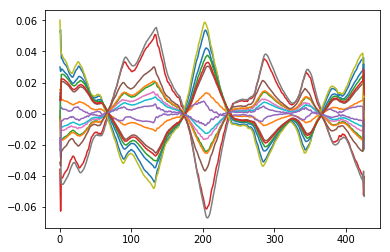

In [10]:
units_conv1 = plotAllActivations('conv1/Conv2D', sequence)
units_conv1[20:-20].shape
units_conv1_con = np.concatenate(units_conv1.T, axis=0)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/matp

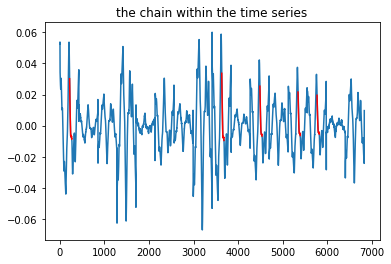

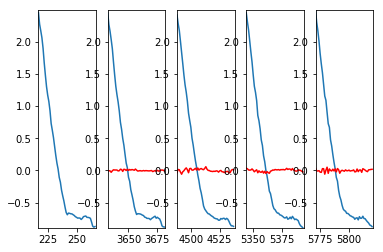

In [11]:
MaxChainLength, Ldiscovered, cur = TSC1_chainlength(units_conv1_con, 50)

In [12]:
cur

6757

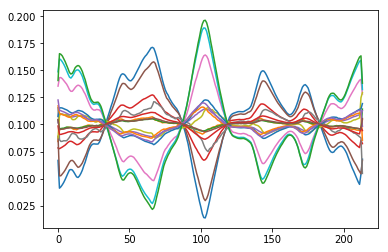

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/matp

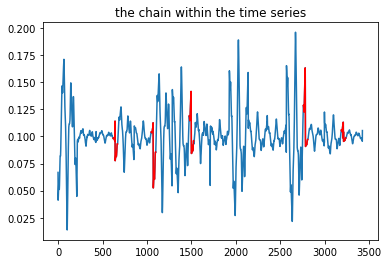

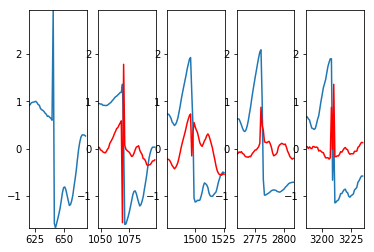

(5.0, array([[0., 0., 0., ..., 0., 0., 0.]]), 3366)

In [13]:
units_pool1 = plotAllActivations('pool1/MaxPool', sequence)
units_pool1[20:-20].shape
units_pool1_con = np.concatenate(units_pool1.T, axis=0)
TSC1_chainlength(units_pool1_con, 50)

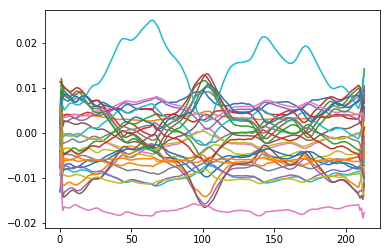

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/matp

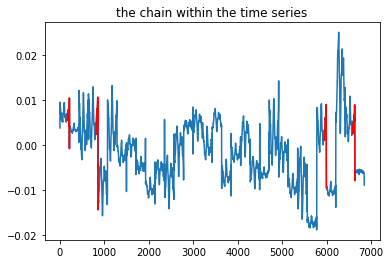

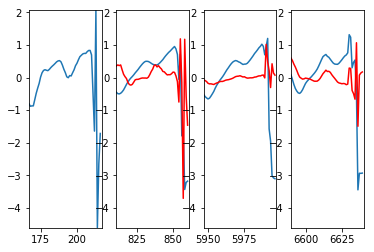

(4.0, array([[0., 0., 0., ..., 0., 0., 0.]]), 6659)

In [14]:
units_conv2 = plotAllActivations('conv2/Conv2D', sequence)
units_conv2[20:-20].shape
units_conv2_con = np.concatenate(units_conv2.T, axis=0)
TSC1_chainlength(units_conv2_con, 50)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/matp

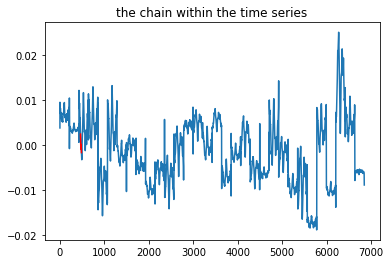

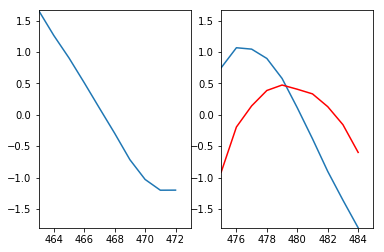

(2.0, array([[0., 0., 0., ..., 0., 0., 0.]]), 2944)

In [15]:
TSC1_chainlength(units_conv2_con, 10)

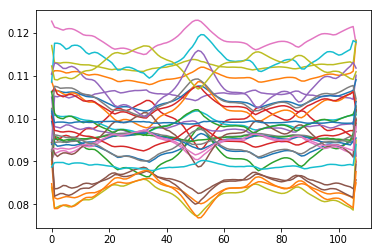

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/matp

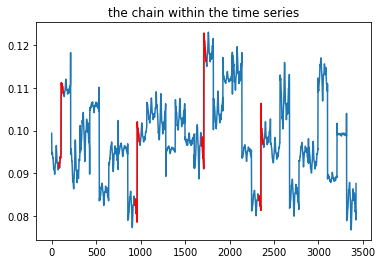

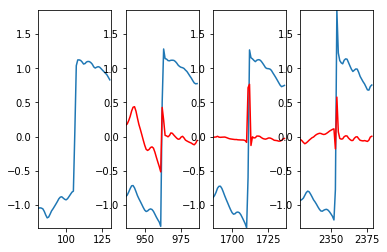

(4.0, array([[0., 0., 0., ..., 0., 0., 0.]]), 3185)

In [16]:
units_pool2 = plotAllActivations('pool2/MaxPool', sequence)
units_pool2[20:-20].shape
units_pool2_con = np.concatenate(units_pool2.T, axis=0)
TSC1_chainlength(units_pool2_con, 50)

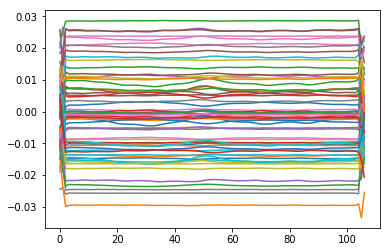

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/matp

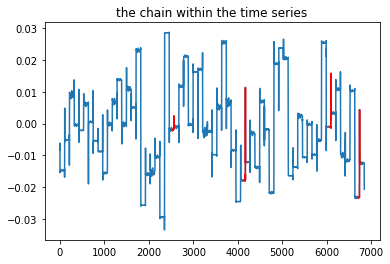

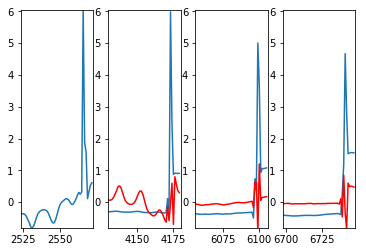

(4.0, array([[0., 0., 0., ..., 0., 0., 0.]]), 6711)

In [17]:
units_conv3 = plotAllActivations('conv3/Conv2D', sequence)
units_conv3[20:-20].shape
units_conv3_con = np.concatenate(units_conv3.T, axis=0)
TSC1_chainlength(units_conv3_con, 50)

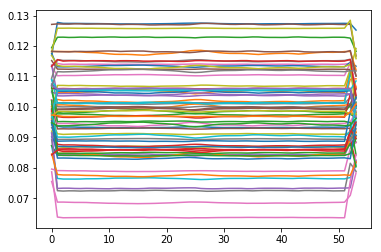

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/matp

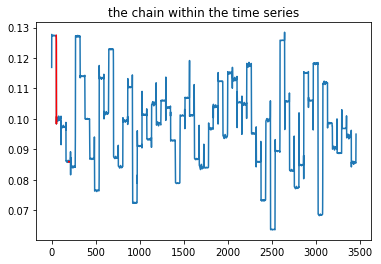

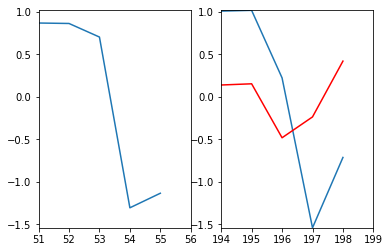

(2.0, array([[0., 0., 0., ..., 0., 0., 0.]]), 3021)

In [18]:
units_pool3 = plotAllActivations('pool3/MaxPool', sequence)
units_pool3.shape
units_pool3_con = np.concatenate(units_pool3.T, axis=0)
TSC1_chainlength(units_pool3_con,5)